In [1]:
# import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# See the first 5 rows and data types
print(df.head())
# technical overview of your dataset's structure rows, column, data type etc. 
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [2]:
# Convert TotalCharges to a numeric type, coercing errors to NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values now
print(df.isnull().sum())

# For simplicity, we'll fill the few missing values with the median.
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop the customerID as it's not a predictive feature
df = df.drop("customerID", axis=1) 

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


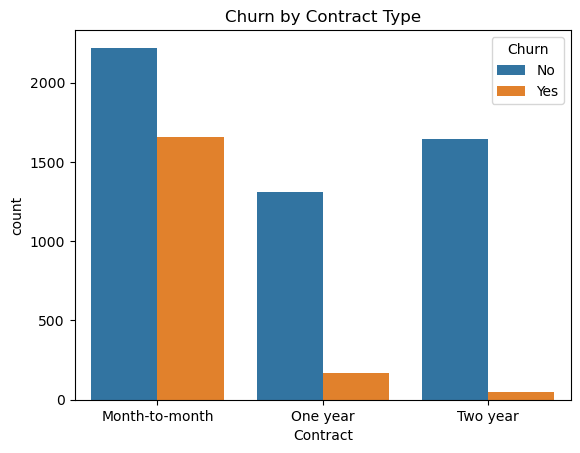

In [2]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

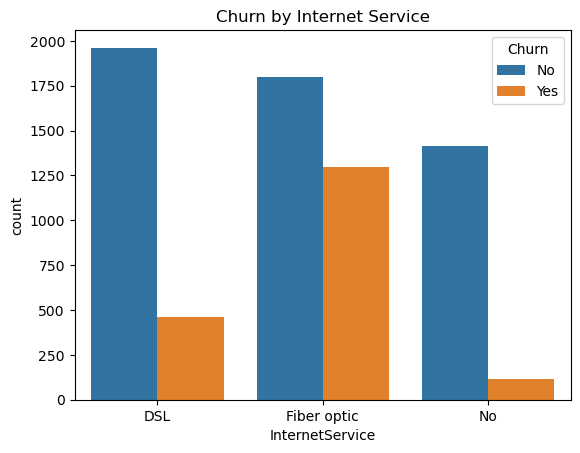

In [3]:
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn by Internet Service')
plt.show()

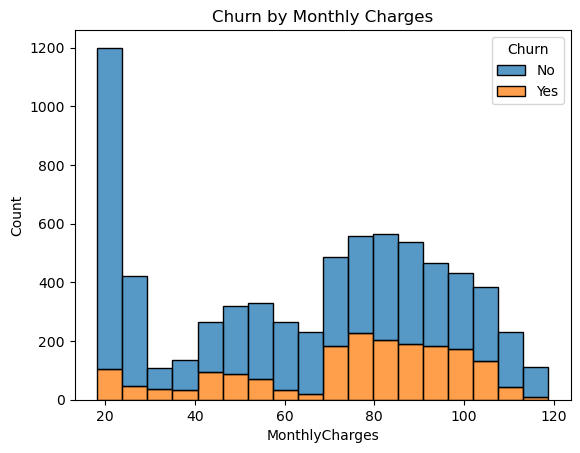

In [4]:
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Churn by Monthly Charges')
plt.show()

In [5]:
# Example: Create a feature for customers with no "add-on" security services
df['NoSecurityServices'] = ((df['OnlineSecurity'] == 'No') &
                           (df['OnlineBackup'] == 'No') &
                           (df['DeviceProtection'] == 'No') &
                           (df['TechSupport'] == 'No')).astype(int)

# Example: Create a 'tenure group' to categorize customer loyalty
def tenure_group(tenure):
    if tenure <= 12:
        return 'New'
    elif tenure <= 48:
        return 'Established'
    else:
        return 'Loyal'
df['TenureGroup'] = df['tenure'].apply(tenure_group)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Convert our target 'Churn' column to 0s and 1s
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Define features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical features (adjust based on your new features)
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype != 'object']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# --- Logistic Regression ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_test)

# --- Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

# --- XGBoost ---
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

# --- Evaluation ---
print("--- XGBoost ---")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, xgb_pipeline.predict_proba(X_test)[:, 1]):.2f}")
print(classification_report(y_test, xgb_preds))

E:\CODE\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:51:53] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
Accuracy: 0.78
ROC AUC: 0.82
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409

